<p style="text-align:center; font-size: 28px;">CS-C4100 - Digital Health and Human Behavior (2024)</p>

In [1]:
ID = "102565223"  # Your Student Id

<div class="alert alert-info">

<details open>
    <summary style="font-size: 22px"><b>⚠️ General Tips</b></summary>

* Please review [the general course info](https://mycourses.aalto.fi/course/view.php?id=44883) carefully.
* Feel free to create new code cells. This is a good way to write extra tests you may want to run. Note that all cells are executed during evaluation. 
* **Never** create new cells by menu commands "Edit/Copy Cells" and "Edit/Paste Cells ...". These commands create cells with duplicate ids and make autograding impossible. Use menu commands "Insert/Insert Cell ..." or the button with a plus sign to insert new cells.
* When you write code required to solve an assignment, we highly recommend you to insert the code where it says `# YOUR CODE HERE`.
* If your notebook is broken (e.g. accidentally removed a hidden tests cell, etc.), you can always re-fetch the assignment. To do so, rename the existing folder and fetch the assignment again.
* Do not forget to "Submit" your solution in the "Nbgrader→Assignment List" page after finishing your work. 
* To better understand how doing assignments in JupyterLab works, please refer to the [documentation](https://scicomp.aalto.fi/aalto/jupyterhub/nbgrader-jupyterlab/).

</details>
</div>

---


# Assignment 3.2: Quantifying Behavior of Groups

Data from mobile devices are high-resolution, meaning that they are segmented into small time intervals (a few seconds). We often want to **downsample** the data, i.e., binning them into bigger bins, to reduce the signal's noise. In this part, you will learn to process and visualize segmented data by implementing the method introduced in the [reading assignment](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-018-0174-4).


### Table of Contents

* [Section 1: Loading the data](#1.-Loading-the-data)
* [Section 2: Preprocessing](#2.-Preprocessing)
* [Section 3: Visualizing](#3.-Visualizing)
    * [Section 3.1: Plotting the Unlocking Activity Pattern](#3.1.-Plotting-the-Unlocking-Activity-Pattern)
    * [Section 3.2: Naive Classifier (Bonus)](#3.2.-Naive-classifier-(1-Bonus-Point))
* [References](#References)

In [1]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

if 'AALTO_JUPYTERHUB' in os.environ:
    # Using jupyter sharedata directory
    DATA = '/coursedata/pa3/as2/'
    TEST_PATH = '/coursedata/pa3/test/'
else:
    DATA = '../../data/pa3/as2/'
    TEST_PATH = '../../data/pa3/test/'

# define global plotting parameters
plt.rcParams.update({'font.size': 20})
sns.set(style="dark", font_scale=2)

## 1. Loading the data
<a class="anchor" id="section_1"></a>

The dataset consists of multiple `csv` files which contain cellphone screen activity records.

You can get the paths of all records by calling the `os.listdir()` function.

In [2]:
files = sorted(os.listdir(DATA))

print(files[:5])

['u072142.csv', 'u0cba7d.csv', 'u11abb4.csv', 'u11cef8.csv', 'u11cf22.csv']


Each `csv` file corresponds to one subject. The name of the `csv` file can be seen as the `Id` of the subject.

In [3]:
# Get one sample data
pd.read_csv(DATA + np.random.choice(files)).head()

,ts,Screen_Value
0,2016-06-19 17:11:26,Unlocked
1,2016-06-19 17:43:10,On
2,2016-06-19 17:43:20,Off
3,2016-06-19 18:36:32,On
4,2016-06-19 18:36:35,Unlocked


The csv file contains the following columns:

1. `ts`: universal timestamp
2. `screen_value`: type of activity, can be either **Unlocked**, **Off** or **On**.

---

## 2. Preprocessing
<a class="anchor" id="section_2"></a>


In this task, we will compute **the daily activity pattern of each subject**. Let's break down the tasks into smaller steps.

<div class="alert alert-warning">

#### 📝 **Task 1**

- **Step 1: Count the number of unlocking events in each hour for each user.**

    - For each user, we want to count how many times they unlock their phone during each hour of the day.
    - Example: The **24 bins** represent 24 hours where the first bin counts all unlocking attempts that happened **during the period of 00:00-00:59**, and the second bin from **01:00-01:59**, etc.


- **Step 2: Aggregate the counts across the bins for each user.**

    - After counting for each user, aggregate these counts to find the total number of unlocking events for each hour, considering all the days they were part of the study.
    - Example: Let's consider User A who stayed in the study for 2 days:

        - **User A:**

            - **Day 1:**

                - 9:00 AM - 5 unlocks

                - 10:00 AM - 7 unlocks

            - **Day 2:**

                - 9:00 AM - 4 unlocks

                - 10:00 AM - 6 unlocks

    - Now, you will want to aggregate these counts:

        - **User A:**

            - 9:00 AM - (5 + 4) = 9 unlocks

            - 10:00 AM - (7 + 6) = 13 unlocks

- **Step 3: Average by dividing the values by the number of days the user remained in the study.**

    - To get an average daily activity pattern, we divide the aggregated counts by the number of days each user was in the study.
    - Example: User A was in the study for 7 days. So, for 9:00 AM, the average count would be (total count for 9:00 AM) / 7.

- **Step 4: *Normalize* the final values.**
    - Finally, we can normalize the values to make them relative.

</div>

<div class="alert alert-success">

<details>
    <summary style="font-size: 18px"><b>💡 Hint</b></summary>

- Create the dict inside the loop, and create the dataframe and apply the requested changes afterwards.
- When reading data from csv-files, you must convert the `date` column into an appropriate data type using the [pd.to_datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) function.
- You can use the following functions: [dt.hour](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.hour.html) and [value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts).
- There might be **missing records** for specific hours. [Fill](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) those empty records with **0**.
- To normalize the values, we utilize [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
</details>
</div>

In [14]:
# Save intermediate results
df = pd.DataFrame()
res = {}

# Read the records
for i in files:
    # Read one record at a time
    record = pd.read_csv(os.path.join(DATA, i))

    # User's id, used to form the final dataframe
    uid = i.split(".")[0]

    # Storing subject results in this dictionary. The keys are the hour and the values are the avarage unlocking attempts per hour
    # Example: {'0': 1.2, '1': '2.3',...,'23':0.1}
    u_res = {}
    record = record[record['Screen_Value'] == 'Unlocked']
    record['Hour'] = pd.to_datetime(record['ts']).dt.hour
    record['Date'] = pd.to_datetime(record['ts']).dt.date
    
    counts = record.groupby(['Date', 'Hour']).size().unstack(fill_value=0)
    total = counts.sum(axis=0)
    totaldays = counts.shape[0]
    u_res = total / totaldays 
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    # Save the results into the dict
    res[uid] = u_res

# Generate the result dataframe
df = pd.DataFrame().from_dict(res)
df = df.fillna(0)

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index) 
# ...

# YOUR CODE HERE
#raise NotImplementedError()

# Unit tests
assert df.shape == (24, 342) or df.shape == (342, 24), "wrong shape of DataFrame"
assert np.isclose(df.iloc[0, 0], 0.502, atol=1e-3)

In [15]:
df.head()

,u072142,u0cba7d,u11abb4,u11cef8,u11cf22,u11e341,u122eec,u1242ba,u12ce86,u137e50,...,uf7e6b5,ufa689c,ufba853,ufbe58a,ufc774b,ufca1e5,ufd6c4a,ufe4de9,ufe50eb,ufff695
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.502519,-0.716446,-0.247144,-0.845189,-1.429684,-1.340057,-0.281466,-0.820677,-0.447531,-0.846101,...,0.304219,-1.120029,0.705906,-0.352210,-1.225439,-1.130676,0.645158,-0.565473,-0.774204,0.287896
1,1.949773,-1.393593,-0.961300,-1.197351,-1.483976,-1.443603,-0.797784,-0.891273,-0.722935,-1.014201,...,-1.074657,-1.453950,0.027056,-1.098067,-1.381877,-1.316286,-0.206450,-0.919365,-1.568047,-1.126944
2,0.422116,-1.224306,-1.397729,-1.197351,-1.483976,-1.629986,-1.443183,-0.114718,-1.108501,-1.249540,...,-1.278098,-1.453950,-1.094523,-1.263813,-1.381877,-1.316286,-0.856769,-1.207416,-1.295163,-1.531185
3,-0.140705,-1.248490,-1.536593,-1.267784,-1.447781,-1.629986,-1.529236,-0.679485,-1.218663,-1.316780,...,-1.413725,-1.453950,-1.330645,-1.263813,-1.381877,-1.316286,-1.367734,-1.355557,-1.419201,-1.546157
4,-1.185945,-1.393593,-1.556431,-1.197351,-1.411586,-1.629986,-1.615289,-1.526636,-1.273743,-1.451259,...,-1.594561,-1.453950,-1.478221,-1.263813,-1.381877,-1.316286,-1.445153,-1.372017,-1.543239,-1.613530


In [16]:
### HIDDEN TESTS

## 3. Visualizing
<a class="anchor" id="section_3"></a>

### 3.1. Plotting the Unlocking Activity Pattern

By plotting individual data against group data, we can observe the difference between an individual's patterns and their group's [1]. We can classify individuals based on their typical behavior [2]. For example, if someone tends to use the phone late in the evening, we can call them *night owls*. Conversely, we classify the people with opposite behavior as *early birds*.

Now, run the following two cells to see the unlocking activity pattern of subjects against the average.

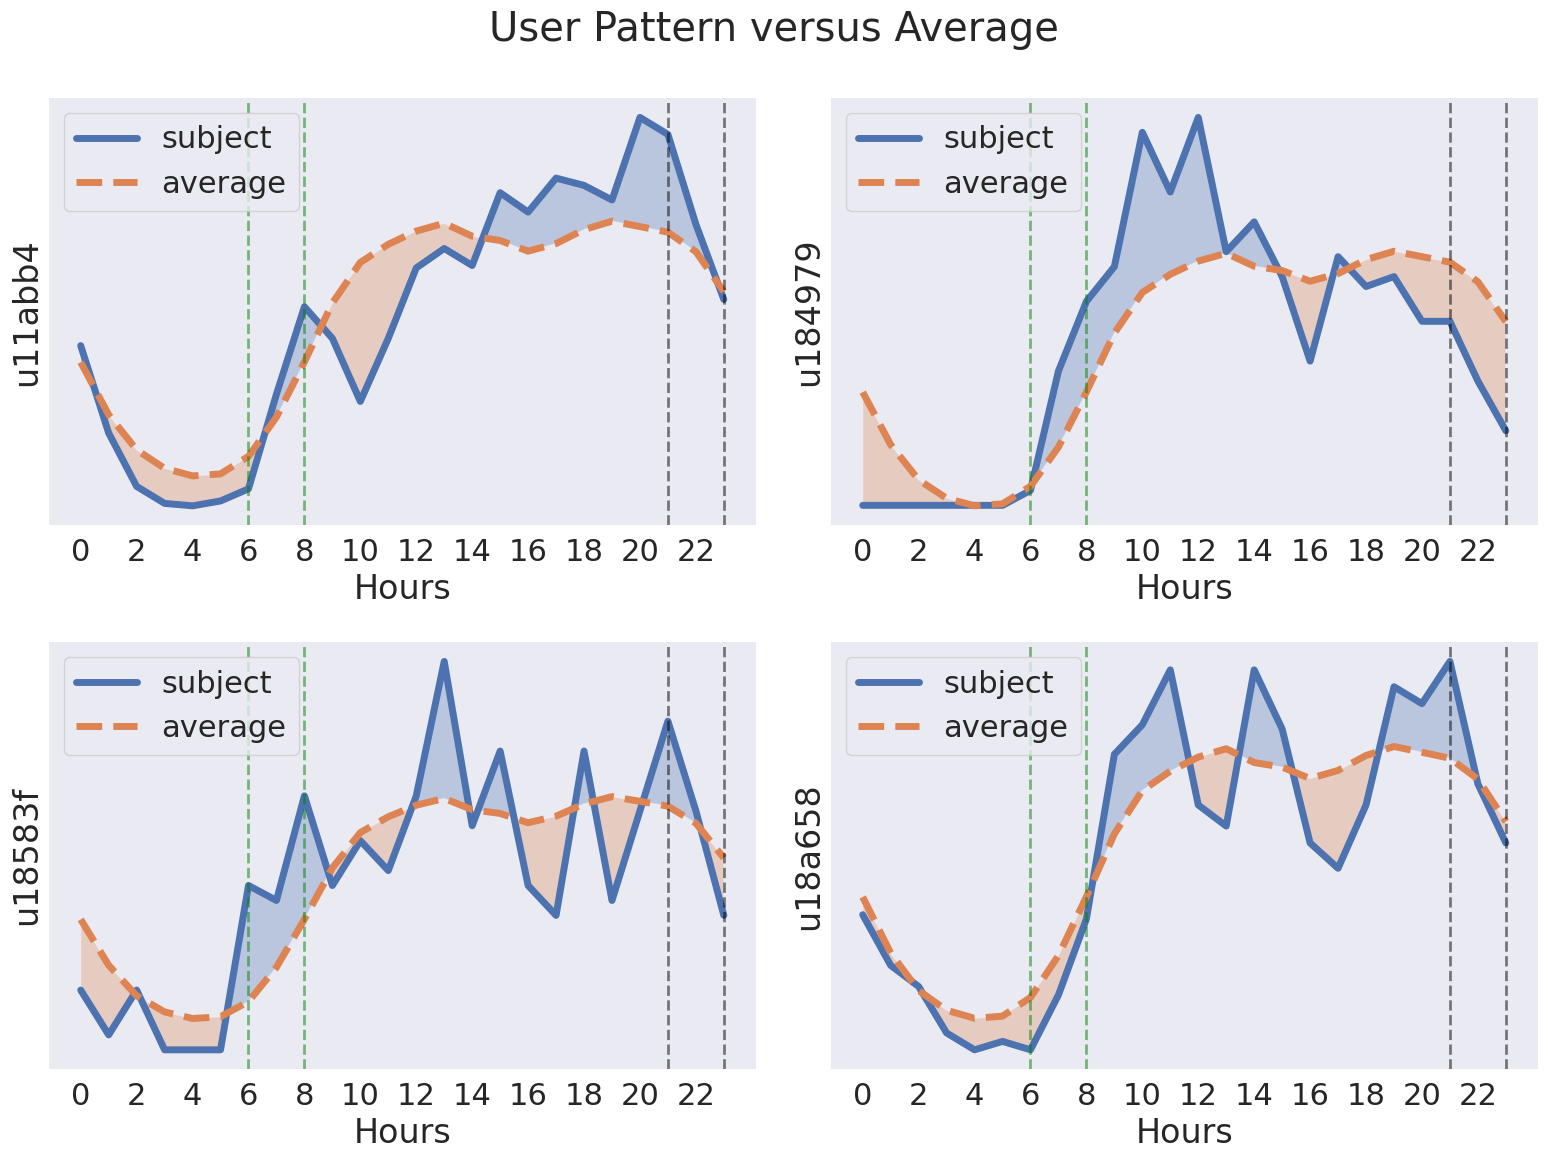

In [31]:
# Calculate the average patterns
average = df.mean(axis="columns")

from helper import plot_subject_vs_average

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_subject_vs_average(df.iloc[:,  2], ax[0, 0], average)
plot_subject_vs_average(df.iloc[:, 15], ax[0, 1], average)
plot_subject_vs_average(df.iloc[:, 16], ax[1, 0], average)
plot_subject_vs_average(df.iloc[:, 17], ax[1, 1], average)

sns.despine(top=True, right=True, left=True, bottom=True)
fig.suptitle("User Pattern versus Average")

plt.tight_layout()
plt.show()

### 3.2. Naive classifier (1 Bonus Point)  
In the next task, you will have to implement a *naive classifier*, which identifies a person as either an early bird or a night owl, based on the relative sum of areas between the personal pattern and the average pattern in the period of 6-8 and 21-23. The person can be classified as an *early bird* if the morning screen activity is higher than the average level and the evening screen activity is lower than the average level. 

<div class="alert alert-warning">

#### 📝 **Task 2 (Extra)**

- Compare the areas enclosed by the blue and orange lines between **6-8** and between **21-23** to determine the label (both ranges closed from both sides).
    - **Note** that having a larger-than-average activity (blue line at the top) in the morning should count as a **positive** value towards being an early bird, whereas having a larger-than-average activity in the evening range counts as a **negative** value for this label, and vice-versa.
- Implement the function in the below cell. The function must return True if the sum of the area between 6-8 and 21-23 is positive, i.e. the person is an *early bird*, and returns Else otherwise.

The hidden tests will also examine some other subjects to evaluate the function.

</div>

In [50]:
def classifier(x: pd.Series) -> bool:
    """
    Returns:
        True for early bird, False for night owl
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    morninghour = [6,7,8]
    eveninghour = [21,22,23]
    morning = abs((x[morninghour] - x[morninghour].mean())).sum()
    evening = abs((x[eveninghour] - x[eveninghour].mean())).sum()
    
    if morning > 0 and evening > 0:
        return True
    
    
assert classifier(df["u184979"]) == True, "Maybe check the description again?"

In [ ]:
### HIDDEN TESTS

---

## References

[1] Aledavood T, López E, Roberts SGB, Reed-Tsochas F, Moro E, Dunbar RIM, et al. (2015) Daily Rhythms in Mobile Telephone Communication. PLoS ONE 10(9): e0138098. https://doi.org/10.1371/journal.pone.0138098

[2] Aledavood T, Lehmann S and Saramäki J (2015) Digital daily cycles of individuals. Front. Phys. 3:73. https://doi.org/10.3389/fphy.2015.00073